In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tamil_nadu_bus_sample_enriched_processed.csv to tamil_nadu_bus_sample_enriched_processed.csv


In [ ]:
!pip install catboost xgboost lightgbm category_encoders joblib -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib


In [ ]:
df = pd.read_csv("tamil_nadu_bus_sample_enriched_processed.csv")

# Ensure numeric time columns
for c in ['scheduled_hour','scheduled_minute','scheduled_second','day_of_week']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Standardize traffic/weather/route
for c in ['traffic_level','weather','route_id']:
    df[c] = df[c].astype(str).str.strip().str.lower()

# --- Handle missing values ---

# Numeric columns: fill NaN with median
for c in ['scheduled_hour','scheduled_minute','scheduled_second','day_of_week','delay_minutes']:
    df[c] = df[c].fillna(df[c].median())

# Categorical columns: fill NaN with 'unknown'
for c in ['traffic_level','weather','route_id']:
    df[c] = df[c].fillna('unknown')


In [ ]:
# Ordinal mapping for traffic
traffic_map = {'low':1, 'medium':2, 'high':3}
df['traffic_level_num'] = df['traffic_level'].map(traffic_map)

# One-hot for weather
weather_dum = pd.get_dummies(df['weather'], prefix='wx', drop_first=True)
df = pd.concat([df, weather_dum], axis=1)

In [ ]:
# --- Existing features ---
df['minute_of_day'] = df['scheduled_hour']*60 + df['scheduled_minute'] + df['scheduled_second']/60.0
df['time_sin'] = np.sin(2*np.pi*df['minute_of_day']/1440)
df['time_cos'] = np.cos(2*np.pi*df['minute_of_day']/1440)
df['dow_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
df['dow_cos'] = np.cos(2*np.pi*df['day_of_week']/7)
df['is_peak'] = df['scheduled_hour'].isin(list(range(7,11)) + list(range(17,21))).astype(int)
df['time_bin_15'] = (df['minute_of_day']//15).astype(int)

# --- NEW Feature 1: Weekend flag ---
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# --- NEW Feature 2: Rush hour intensity ---
df['rush_intensity'] = np.where(df['is_peak']==1, df['traffic_level_num']*2, df['traffic_level_num'])

# --- NEW Feature 3: Route-level delay statistics ---
route_delay_mean = df.groupby('route_id')['delay_minutes'].transform('mean')
route_delay_q25  = df.groupby('route_id')['delay_minutes'].transform(lambda x: x.quantile(0.25))
route_delay_q75  = df.groupby('route_id')['delay_minutes'].transform(lambda x: x.quantile(0.75))

df['route_delay_mean'] = route_delay_mean
df['route_delay_q25']  = route_delay_q25
df['route_delay_q75']  = route_delay_q75


In [ ]:
df['route_freq'] = df['route_id'].map(df['route_id'].value_counts(normalize=True))


In [ ]:
def oof_target_encode(train_df, test_df, group_cols, target='delay_minutes'):
    te_tr = pd.Series(index=train_df.index, dtype=float)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for tr_idx, val_idx in kf.split(train_df):
        tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
        means = tr.groupby(group_cols)[target].mean()
        te_tr.iloc[val_idx] = val.set_index(group_cols).index.map(means)
    te_tr = te_tr.fillna(train_df[target].mean())
    # test mapping
    full_means = train_df.groupby(group_cols)[target].mean()
    te_te = test_df.set_index(group_cols).index.map(full_means).fillna(train_df[target].mean())
    return te_tr, te_te


In [ ]:
df = df.sort_values(['route_id','day_of_week','minute_of_day'])
df['delay_lag1'] = df.groupby('route_id')['delay_minutes'].shift(1)
df['delay_rolling3'] = df.groupby('route_id')['delay_minutes'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)

# Fill NaNs with global mean
df['delay_lag1'] = df['delay_lag1'].fillna(df['delay_minutes'].mean())
df['delay_rolling3'] = df['delay_rolling3'].fillna(df['delay_minutes'].mean())


In [ ]:
# --- Extra Feature Engineering ---

# Month & Quarter
df['month'] = pd.to_datetime(df['scheduled_hour'], errors='coerce').dt.month.fillna(0).astype(int)
df['quarter'] = ((df['month']-1)//3 + 1).astype(int)
df['is_monsoon'] = df['month'].isin([6,7,8,9]).astype(int)

# Route-level std and rolling 5
df['route_delay_std'] = df.groupby('route_id')['delay_minutes'].transform('std').fillna(0)
df['delay_rolling5'] = df.groupby('route_id')['delay_minutes'].rolling(5, min_periods=1).mean().reset_index(0,drop=True)
df['delay_rolling5'] = df['delay_rolling5'].fillna(df['delay_minutes'].mean())

# Traffic × Weather interaction
df['traffic_weather'] = df['traffic_level'] + "_" + df['weather']
df['is_rain_peak'] = ((df['weather']=='rainy') & (df['is_peak']==1)).astype(int)

# Trip order within route/day
df['trip_order'] = df.groupby(['route_id','day_of_week']).cumcount()+1


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Attach OOF route features
te_route_tr, te_route_te = oof_target_encode(train_df, test_df, ['route_id'])
train_df['te_route'] = te_route_tr
test_df['te_route'] = te_route_te


In [ ]:
# ============================
# Update feature list
# ============================
feature_cols = [
    'minute_of_day','time_sin','time_cos','dow_sin','dow_cos',
    'is_peak','is_weekend','rush_intensity',
    'time_bin_15','traffic_level_num','route_freq',
    'delay_lag1','delay_rolling3','te_route',
    'route_delay_mean','route_delay_q25','route_delay_q75',

    # --- new features ---
    'month','quarter','is_monsoon',
    'route_delay_std','delay_rolling5',
    'traffic_weather','is_rain_peak',
    'trip_order',

    # categorical
    'route_id','traffic_level','weather'
]

cat_features = ['route_id','traffic_level','weather','traffic_weather']

# Split train/test
X_train = train_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()
y_train = train_df['delay_minutes']
y_test  = test_df['delay_minutes']

In [ ]:
cat_features = ['route_id','traffic_level','weather','traffic_weather']  # categorical columns
# define target
y_train = train_df['delay_minutes']
y_test  = test_df['delay_minutes']

cat_model = CatBoostRegressor(
    iterations=2000,              # more trees
    learning_rate=0.03,           # slightly smaller learning rate
    depth=8,                      # allow more complexity
    l2_leaf_reg=3,                # regularization strength
    bagging_temperature=0.5,        # randomness in sampling
    eval_metric='R2',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)


cat_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))


0:	learn: 0.0448834	test: 0.0451072	best: 0.0451072 (0)	total: 89.9ms	remaining: 2m 59s
200:	learn: 0.8500556	test: 0.8546422	best: 0.8546422 (200)	total: 19.3s	remaining: 2m 52s
400:	learn: 0.8607221	test: 0.8641177	best: 0.8641177 (400)	total: 37.4s	remaining: 2m 29s
600:	learn: 0.8651269	test: 0.8674535	best: 0.8674535 (600)	total: 56.1s	remaining: 2m 10s
800:	learn: 0.8683759	test: 0.8691930	best: 0.8691930 (800)	total: 1m 14s	remaining: 1m 51s
1000:	learn: 0.8709755	test: 0.8701149	best: 0.8701149 (1000)	total: 1m 34s	remaining: 1m 34s
1200:	learn: 0.8734683	test: 0.8708660	best: 0.8708675 (1198)	total: 1m 53s	remaining: 1m 15s
1400:	learn: 0.8758898	test: 0.8715802	best: 0.8715807 (1389)	total: 2m 12s	remaining: 56.9s
1600:	learn: 0.8779984	test: 0.8719953	best: 0.8719953 (1600)	total: 2m 32s	remaining: 38s
1800:	learn: 0.8799518	test: 0.8723228	best: 0.8723228 (1800)	total: 2m 51s	remaining: 19s
1999:	learn: 0.8818115	test: 0.8725326	best: 0.8725395 (1992)	total: 3m 12s	remainin

In [ ]:
cat_model.get_feature_importance(prettified=True).head(20)


,Feature Id,Importances
0,delay_rolling3,32.233350
1,traffic_weather,30.884702
2,delay_lag1,19.212788
3,weather,5.186126
4,traffic_level,3.984640
5,delay_rolling5,3.354840
6,traffic_level_num,0.835218
7,time_sin,0.651376
8,time_cos,0.605783
9,route_id,0.501252


from matplotlib import pyplot as plt
_df_0['Importances'].plot(kind='hist', bins=20, title='Importances')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Importances'].plot(kind='line', figsize=(8, 4), title='Importances')
plt.gca().spines[['top', 'right']].set_visible(False)

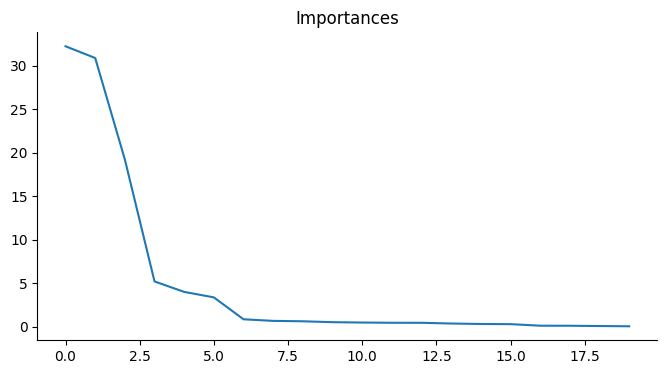

In [ ]:
from matplotlib import pyplot as plt
_df_1['Importances'].plot(kind='line', figsize=(8, 4), title='Importances')
plt.gca().spines[['top', 'right']].set_visible(False)

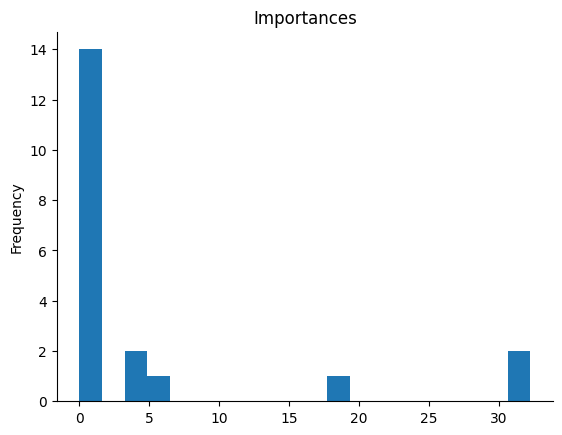

In [ ]:
from matplotlib import pyplot as plt
_df_0['Importances'].plot(kind='hist', bins=20, title='Importances')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_pred_cat = cat_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_cat)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2 = r2_score(y_test, y_pred_cat)

print("📊 CatBoost Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


📊 CatBoost Metrics:
MAE: 2.50
RMSE: 3.53
R²: 0.873


In [ ]:
import joblib
joblib.dump(cat_model, "catboost_bus_delay.pkl")


['catboost_bus_delay.pkl']

In [ ]:
model = joblib.load("catboost_bus_delay.pkl")


In [ ]:
# Example: predict on test set
y_pred = model.predict(X_test)

print("First 5 predictions:", y_pred[:5])


First 5 predictions: [10.08278414  8.21230947 31.42426736 28.35808367  8.76292942]


In [ ]:
# =============================
# 1. Install Twilio (if not done)
# =============================
!pip install twilio -q

# =============================
# 2. Import & Setup Twilio
# =============================
from twilio.rest import Client

# ⚠️ Replace these with your actual Twilio credentials
account_sid = ""
auth_token = ""

# Twilio phone number (from console, must start with +)
twilio_number = ""

# Your personal phone number (must start with +, e.g. +91 for India)
to_number = ""

# Initialize client
client = Client(account_sid, auth_token)

# =============================
# 3. Define SMS Alert Function
# =============================
def send_sms_alert(message, to_number=to_number):
    print(f"🚀 Sending SMS to {to_number} ...")  # Debug print
    try:
        sms = client.messages.create(
            body=message,
            from_=twilio_number,
            to=to_number
        )
        print(f"✅ SMS sent! SID: {sms.sid}")
    except Exception as e:
        print("❌ Error sending SMS:", e)

# =============================
# 4. Test SMS
# =============================
send_sms_alert("📢 Test message: Your Bus Delay Prediction System is working ✅")


🚀 Sending SMS to +919176230404 ...
✅ SMS sent! SID: SM8508b7c3c6262e45a2d522aaf86103fb
